# Forward Rate Agreement (FRA)

## Valuation

$\textbf{FRA}=\tau KP(t, S)-P(t, T) + P(t,S)$

### Exact Calculation

Let's evaluate a FRA using $\texttt{tensorquant}$...

In [1]:
!pip install -q tensorquant

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 1.4 MB/s eta 0:00:00


In [5]:
import tensorquant as tq, pandas as pd
from datetime import date, datetime

tq.Settings.evaluation_date = date(2025, 4, 3)
evaluation_date = tq.Settings.evaluation_date
calendar = tq.TARGET()
rates_estr = [0.045, 0.045, 0.045, 0.045]
times_estr = [datetime.strptime(d, "%Y-%m-%d").date() for d in ['2025-07-01', '2028-01-01', '2028-04-01', '2029-01-01']]
market_data = {}
market_data["IR:EUR:ESTR"] = market_data["IR:EUR:3M"] = tq.RateCurve(reference_date=evaluation_date,
                                                                     pillars=times_estr, rates=rates_estr, interp='LINEAR',
                                                                     daycounter_convention=tq.DayCounterConvention.ActualActual)
eur3m_index = tq.IborIndex(calendar, 3, tq.TimeUnit.Months, tq.Currency.EUR, 2)
eur3m_index.add_fixing(evaluation_date, 0.045)

notional=100e6
fixed_rate = 0.04

eur_fra_builder = tq.FraGenerator(ccy=tq.Currency.EUR, start_delay=2, fixing_days=2, index_term="3M",
                                  roll_convention= tq.BusinessDayConvention.ModifiedFollowing, notional=notional,
                                  day_count_convention=tq.DayCounterConvention.Actual360, calendar=tq.TARGET(), index=eur3m_index)
fra = eur_fra_builder.build(trade_date=evaluation_date, quote=fixed_rate, term="3M-12M")
fra_engine = tq.FraPricer(tq.market_map)
fra_engine.price(fra, market_data, True)

print(f"NPV FRA: {fra.price :,.0f}")

NPV FRA: 325,890


### Approximated Calculation

Now let's use a much simplified (but not fully correct) $\texttt{python}$ code...

In [7]:
import numpy as np

class DiscountCurve:
  def __init__(self, pillar_dates, discount_factors):
    self.discount_factors = np.array(discount_factors)
    self.pillar_dates = pillar_dates

  def df(self, adate):
    pillars = [p.toordinal() for p in self.pillar_dates]
    return np.interp(adate.toordinal(), pillars, self.discount_factors)

In [8]:
class FRA:
  def __init__(self, today, nominal, fixing_date, maturity, fixed_rate):
    self.t = today
    self.T = fixing_date
    self.S = maturity
    self.N = nominal
    self.K = fixed_rate

  def npv(self, dc):
    tau = (self.S - self.T).days/360
    P_tS = dc.df(self.S)
    P_tT = dc.df(self.T)
    return self.N*(P_tS*tau*self.K - P_tT + P_tS)

In [10]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

today = date(2025, 4, 3)
rates_estr = [0.045, 0.045, 0.045, 0.045]
pillars = [today] + [datetime.strptime(d, "%Y-%m-%d").date() for d in ['2025-07-01', '2028-01-01', '2028-04-01', '2029-01-01']]
dfs = [1.0, 0.9891, 0.8837, 0.8738, 0.8448]
dc = DiscountCurve(pillars, dfs)

N = 100e6
fixing_date = today + relativedelta(months=3)
maturity = today + relativedelta(months=12)
K = 0.04
fra = FRA(today, N, fixing_date, maturity, K)
print (f"FRA NPV: {-fra.npv(dc):,.0f}")

FRA NPV: 245,331


# Swap as Collection of FRA's

$$\textbf{RFS} = N\sum_{i=\alpha+1}^{\beta}\tau_i P(t,T_i)(K-F(t;T_{i-1},T_i))$$

  1. in a *Receiver Swap* with an increasing yield curve the first FRAs will have negative value, the last positive.
  2. in a *Receiver Swap* with a decreasing yield curve the first FRAs will have positive value, the last negative.

In [2]:
from datetime import date
from dateutil.relativedelta import relativedelta

def TimeInterval(interval):
    tag = interval[-1].lower()
    value = int(interval[:-1])
    if tag == "d":
        return relativedelta(days=value)
    elif tag == "m":
        return relativedelta(months=value)
    elif tag == "y":
        return relativedelta(years=value)
    else:
        raise ValueError(f"Unable to convert {interval}, probably wrong units.")

def generate_dates(start_date, end_date, frequency="1y"):
    if isinstance(end_date, str):
        end_date = start_date + TimeInterval(end_date)
    d = start_date
    dates = [start_date]
    while True:
        d += TimeInterval(frequency)
        if d < end_date:
            dates.append(d)
        else:
            dates.append(end_date)
            break
    return dates

In [4]:
class InterestRateSwap:
    def __init__(self, nominal, start_date, maturity,
                 fixed_rate, frequency_float, frequency_fix="12m", side=1):
        self.N = nominal
        self.K = fixed_rate
        self.fix_dates = generate_dates(start_date, maturity, frequency_fix)
        self.float_dates = generate_dates(start_date, maturity, frequency_float)
        self.side = side

    def npv_with_FRA(self, dc):
        fras = []
        for i in range(1, len(self.fix_dates)):
            fras.append(FRA(self.fix_dates[0], self.N,
                            self.fix_dates[i-1], self.fix_dates[i], self.K))

        vals = [self.side*f.npv(dc) for f in fras]
        return sum(vals), vals

    def swap_rate(self, dc):
        den = 0
        num = dc.df(self.fix_dates[0]) - dc.df(self.fix_dates[-1])
        for i in range(1, len(self.fix_dates)):
            tau = (self.fix_dates[i]-self.fix_dates[i-1]).days/360
            den += dc.df(self.fix_dates[i])*tau
        return num/den

In [11]:
import matplotlib.pyplot as plt

from datetime import date
from dateutil.relativedelta import relativedelta

def makePFS(rates):
  vals = []
  today = date.today()
  dfs = [1] + [1/(1+rates[i])**i for i in range(1, len(rates))]
  pillars = [today] + [today+relativedelta(years=i) for i in range(1, len(rates))]
  dc = DiscountCurve(pillars, dfs)
  dummy_irs = InterestRateSwap(1, today, "5y", 0.1, "1y", side=1)
  swap_rate = dummy_irs.swap_rate(dc)
  irs = InterestRateSwap(1, today, "5y", swap_rate, "1y", side=1)
  val, vals = irs.npv_with_FRA(dc)
  plt.plot(range(len(rates)), rates, linestyle="--", label=r"Interest rates $r$")
  plt.scatter(range(1, len(vals)+1), vals, color='red', label="FRA")
  plt.hlines(0, 0, 6, color='black', linestyle=":")
  plt.xlim(0, 6)
  plt.ylim(-0.1, 0.2)
  plt.xlabel("Year")
  plt.legend()
  plt.show()

Increasing rates
++++++++++++++++


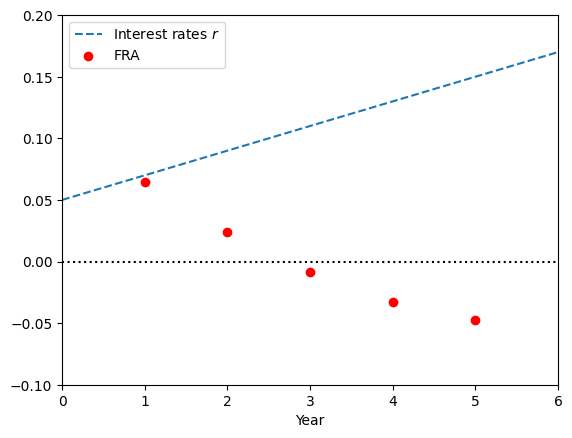

In [12]:
print ("Increasing rates")
print ("++++++++++++++++")
makePFS([0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17])


Decreasing rates
++++++++++++++++


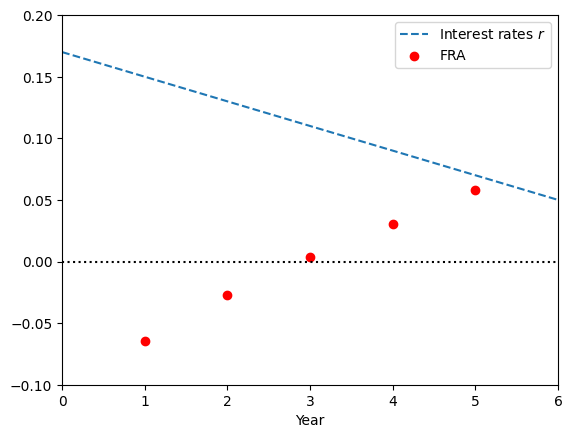

In [13]:
print ("\nDecreasing rates")
print ("++++++++++++++++")
makePFS(list(reversed([0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17])))


Flat rates
++++++++++++++++


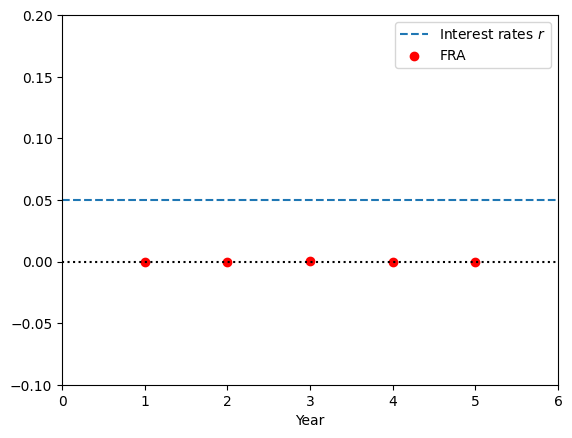

In [14]:
print ("\nFlat rates")
print ("++++++++++++++++")
makePFS([0.05] * 7)